# Dataset Analysis

You can [downloaded the data from Kaggle](https://www.kaggle.com/datasets/googleai/pfam-seed-random-split), inspect it and uploaded it to drive


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Extract the data (takes around 35 seconds)
!unzip drive/MyDrive/PFam/archive.zip >> /tmp/log.txt && echo "data unzipped"

data unzipped


In [3]:
!ls random_split/random_split/

dev  test  train


Reading the data - functions adapted from the starter code by the data providers

https://www.kaggle.com/code/drewbryant/starter-pfam-seed-random-split

In [4]:
# Libraries needed for data analysis
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [5]:
# function to read the data from Kaggle starter code
# https://www.kaggle.com/code/drewbryant/starter-pfam-seed-random-split

def read_all_shards(partition='dev', data_dir="random_split/random_split/"):
    shards = []
    for fn in os.listdir(os.path.join(data_dir, partition)):
        with open(os.path.join(data_dir, partition, fn)) as f:
            shards.append(pd.read_csv(f, index_col=None))
    return pd.concat(shards)

test = read_all_shards('test')
dev = read_all_shards('dev')
train = read_all_shards('train')

partitions = {'test': test, 'dev': dev, 'train': train}
for name, df in partitions.items():
    print('Dataset partition "%s" has %d sequences' % (name, len(df)))

Dataset partition "test" has 126171 sequences
Dataset partition "dev" has 126171 sequences
Dataset partition "train" has 1086741 sequences


The data was read properly based on the number of sequences and the data description on Kaggle. The split for trainig, validation and testing is around 80-10-10, which is reasonable.

In [6]:
# Check each of these separately to verify that data is read correctly
# dev.head()
# dev.tail()
# test.head()
# test.tail()
# train.head()
train.tail()

,family_id,sequence_name,family_accession,aligned_sequence,sequence
13433,IMS_C,Q47EP4_DECAR/219-335,PF11799.8,......PQK..PFAF....PESFAIDLELPARVEHAEALAFAGQRL...,PQKPFAFPESFAIDLELPARVEHAEALAFAGQRLFAALAGWLHGRQ...
13434,Methyltransf_11,COQ3_HUMAN/151-250,PF08241.12,LDV...GC.G.GGLLTEPLG....RLG.......ASVIGIDPVDEN...,LDVGCGGGLLTEPLGRLGASVIGIDPVDENIKTAQCHKSFDPVLDK...
13435,NUDIX_4,R6X4Q2_9BACT/285-402,PF14815.6,HYLYIIY..K....G..K..TW.LSRRKG.K.D.IWEGLYE.FPL....,HYLYIIYKGKTWLSRRKGKDIWEGLYEFPLIETDKAMDFAELQTTD...
13436,YcgR,D9SF05_GALCS/20-124,PF07317.12,YRITSPREIEFVLLNIVKHASRIALYFSE.ENDFILTKLLAVDSTG...,YRITSPREIEFVLLNIVKHASRIALYFSEENDFILTKLLAVDSTGL...
13437,CobD_Cbib,R5PAX6_9CLOT/11-309,PF03186.13,IIIAC....LLDLI........FGD........P..HWL....WHP...,IIIACLLDLIFGDPHWLWHPVQGMGWLIDHVEAWMRKRFRIREDRD...


The dataset seems to have been read properly and is well structured

In [7]:
#Drop the columns that are not to be used
train = train[["family_id", "sequence"]]
dev = dev[["family_id", "sequence"]]
test = test[["family_id", "sequence"]]

There are four questions about the data that I will addresss in this section, several of them are inspired from reading the original article:

1- How many examples of sequences is in each family (or the family size)? Is it balanced?

2- Do the training, validation and testing sets have all the families in common?

3- What's the length of these sequences?

4- What is the frequency of each letter (amino acid) in the sequences?

**1.   How many examples of sequences is in each family (or the family size)?  is it balanced?**


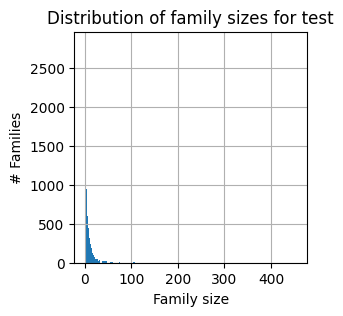

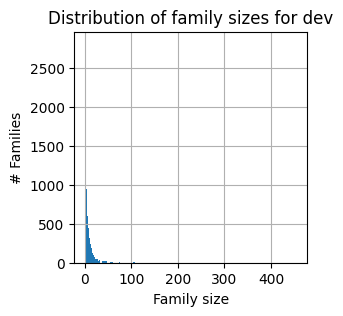

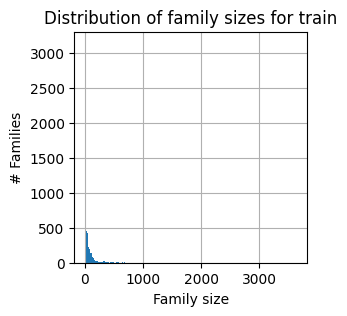

In [8]:
for name, partition in partitions.items():
  plt.figure(figsize=[3,3])  # reducing the size for display
  partition.groupby('family_id').size().hist(bins='auto')
  plt.title('Distribution of family sizes for %s' % name)
  plt.ylabel('# Families')
  plt.xlabel('Family size')
  plt.show()

Based on these histograms, it seems that there is a massive imbalance in the family sizes! Since the histogram is very imbalanced, let's print some indicative numbers:

In [9]:
for size in [3, 10, 100, 300, 1000, 3000]:
  print('Number of family having less than {} examples is '.format(size),  np.count_nonzero(train.groupby('family_id').size().sort_values().values < size))

Number of family having less than 3 examples is  1445
Number of family having less than 10 examples is  5568
Number of family having less than 100 examples is  15161
Number of family having less than 300 examples is  17237
Number of family having less than 1000 examples is  17903
Number of family having less than 3000 examples is  17928


The vast mojority of the families don't have even 100 examples that be used for training. Also, more than 5000 families have less than 10 examples, meaining, there's a high probablity that a random split of train-dev-test sets generated sets that don't have families in common (unless if the split was not actually random). This is checked next.

**2.   Do the train, dev and test sets have all the families in common?**

In [10]:
# Convert the 'family_id' columns from each DataFrame to sets to easily find the instersection
train_ids = set(train['family_id'])
validation_ids = set(dev['family_id'])
test_ids = set(test['family_id'])

# print the size of each set
for name, set_ids in {'validation': validation_ids, 'test': test_ids, 'train': train_ids}.items():
  print('There are {} family ids in the {} set'.format(name, len(set_ids)))

print(' ')

# Find the intersection (common elements) between the sets
for name, set_ids in {'validation': validation_ids, 'test': test_ids}.items():
  common_ids = len(train_ids.intersection(train_ids, set_ids))
  print('There are {} family ids in common between training and {} sets'.format(common_ids, name))
common_ids = len(train_ids.intersection(test_ids, validation_ids))
print('There are {} family ids in common between test and validation sets'.format(common_ids))

There are validation family ids in the 13071 set
There are test family ids in the 13071 set
There are train family ids in the 17929 set
 
There are 13071 family ids in common between training and validation sets
There are 13071 family ids in common between training and test sets
There are 13071 family ids in common between test and validation sets


The train set has ~5000 (17929 - 13071) families that dont' have matches in the validation and test sets! But the validation and test sets have all the families in common


**3.   What's the length of these sequences?**

It's enough to see it in the training set since it contains 80% of the data:

the length of the shortest sequence is 4
the length of the longest sequence is 2037
the average length of the sequences is 155.37997094063812


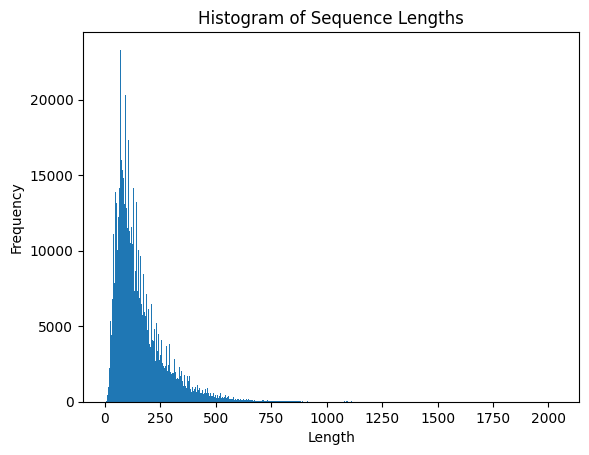

In [12]:
length = train['sequence'].str.len()
print('the length of the shortest sequence is {}'.format(train['length'].min()))
print('the length of the longest sequence is {}'.format(train['length'].max()))
print('the average length of the sequences is {}'.format(train['length'].mean()))

plt.hist(length, bins='auto')
plt.title('Histogram of Sequence Lengths')
plt.xlabel('Length')
plt.ylabel('Frequency')
plt.show()

There's a large difference between the minimum and maximimum length of the sequences. A careful decision needs to be made to pad short sequences and trancate very long sequences. Let's print some numbers on the leghts of these sequences for more understanding:

In [12]:
for size in [10, 30, 100, 200, 300, 1000]:
  print('Number of a sequences shorted than {} amino acids is {}'.format(size, train[train['length'] < size].shape[0]))

Number of a sequences shorted than 10 amino acids is 90
Number of a sequences shorted than 30 amino acids is 22388
Number of a sequences shorted than 100 amino acids is 432076
Number of a sequences shorted than 200 amino acids is 823393
Number of a sequences shorted than 300 amino acids is 970229
Number of a sequences shorted than 1000 amino acids is 1085794


**4.    What is the frequency of each letter (amino acid) in the sequences?**

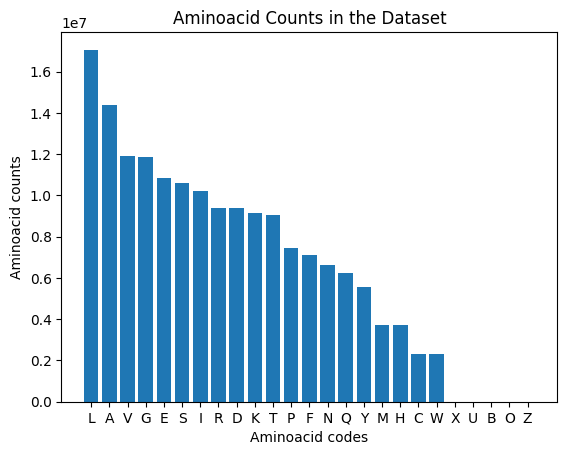

6721

In [13]:
# Explode the DataFrame such that each amino acid in each sequence gets its own row
amino_acids = train['sequence'].apply(lambda x: list(x)).explode().reset_index(drop=True)

# Use value_counts to get the count of each amino acid, then sort by the count
amino_acid_counts = amino_acids.value_counts().sort_values(ascending=False)

plt.figure()
plt.bar(amino_acid_counts.index, amino_acid_counts.values)
plt.xlabel("Aminoacid codes")
plt.ylabel("Aminoacid counts")
plt.title("Aminoacid Counts in the Dataset")
plt.show()

# free the memory from the exploded data frame (1.3 GB)
import gc
del amino_acids
gc.collect()

It seems that some amino acids are very rare! Out of the 26 amino acids, 5 are significantly under represented. This will require an important consideration during the tokenization. Usually, the rare words (here, characters) are assigned to the same token.

# Method Explanation

The original study that published the Pfam dataset (Bileschi et al.) was based on convolutional neural networks (CNNs). The citing literature of that study have not proposed a significantly more efficient deep learning method for classifying protien sequences into families. Several citing literature indicated that transformers can be used as well, but they do not necessarly lead better results in similar tasks (i.e., tasks involving the study of protien sequences to determine its function or family), and that transformers are more computationally demanding to train (Yang at al., Zhou et al. and Xu et al.). The citing literature shows that the nature of these protien sequences makes the properties of CNNs (especially their positional invariance thanks to their pooling layers), a powerful inductive bias.

Inspired from the literature and to insure computational efficiency on a Google Colab network (or a basic laptop), a CNN-based solution seems like an appropriate starting point. Nevertheless, the CNN implementation of the complete approach proposed by (Bileschi et al.), i.e., ProtCNN, remains computationally demanding based on the reporting in the study. Their computational demand is, and I quote, Google Cloud Platform: a n1-standard-32 (32-core / 120 GB RAM) instance for CPU-only and a n1-standard-8 (8-core 32GB RAM) + NVIDIA P100 GPU instance for GPU testing, end quote.

In the CNN-based solution proposed in this notebook, I draw inspiration from a much simpler CNN architecture proposed by (Xu at al.), and used it in a way similar to (Bileschi et al.)- which will be explained later in this section. Noteworthy, not all the hyperparameters used for the CNN in (Xu at al.) were easy to find, and I made some intuitive guesses and kept as many hyperparameters as variabiles to allow tuning (instead of hardcoding them).

In the following, I discuss the practical considerations that I had to follow for implementing a proof-of-concept CNN-based solution.

Removing the families that are uncommon between the train, dev and test sets is a necessary, since one cannot be sure if a trained model will memorize these examples from the trainin set (overfit) or generalize without benchmarking on unseen examples in the dev and test sets.

Even when these families are removed, there will still be a large imbalance between the size of each family in the dataset. The original study (Bileschi et al.) used a subset of the first most populated classes during training a CNN, and once the model is trained, it was used for embedding and clustering sequences from unseen families. I will explore a simplified version of this approach.

It is also noteworthy that the Kaggle data description does not make it forbidden to use the aligned sequences as features for deep learning, but similar to what is discussed by Bileschi et al., I do not see the same advantage compared to using raw sequences (i.e., if a new sequence is to be aligned, then one will still need to align a sequence against all families before using deep leanring). Hence, I will use the raw sequences as features as in (Bileschi et al.). However, it is inspiring to see that the aligned segments of these sequences are sparse. Meaning, if we crop the sequences (as it might be a necessity for computational efficiency), there is still a fair probability that some segments of the sequences can be used by the network for assigning the sequence to its corresponding family.

Bileschi, M.L., Belanger, D., Bryant, D.H. et al. Using deep learning to annotate the protein universe. Nat Biotechnol 40, 932–937 (2022). https://doi.org/10.1038/s41587-021-01179-w

Yang, K. K., Fusi, N., & Lu, A. X. Convolutions are competitive with transformers for protein sequence pretraining (2022). Cell Systems. https://doi.org/10.1016/j.cels.2024.01.008

G. Zhou and W. Chen, "Protein Functional Family Classification Based on Multilevel Feature Information," 2022 IEEE International Conference on Bioinformatics and Biomedicine (BIBM), Las Vegas, NV, USA, 2022, pp. 1836-1839,
https://doi.org/10.1109/BIBM55620.2022.9994943

Xu, Yuting, et al. "Deep dive into machine learning models for protein engineering." Journal of chemical information and modeling 60.6 (2020): 2773-2790. https://doi.org/10.1021/acs.jcim.0c00073

# Experiment Description

**Keeping only a the most populated families for supervized-training of CNN based classifier, and attempting to generalize to other families via unsupervized clustering**

As mentioned Methods, this notebook will train a CNN-based classifier on a subset of the most populated families, and will infer the trained model, based on the learned embedding, to perform clustering on sequences from other (unseen) families. The logic behind this approach, is that the model after training on large enough number examples and families can extract meaningful features allowing to generalize to cluster unseen sequences into new families. Inspired from this approach, in the next steps, I will train a CNN on a subset of the most populated families (keeping into account the computationally feasbiblity and efficiency), and I will examine the generalability of resultant model to cluster sequences from unseen families via embedding and dimensionality reduction.

**1- Keeping only a the most populated families for supervized-training of a classifier**

In [14]:
family_sizes = train.groupby('family_id').size()

# Keeping the families that have more than a certain number of training sequences
# (this threshold was found by trial and error to ensure computational efficiency)
threshold = 500
families_to_keep = family_sizes[family_sizes > threshold]
print('When keeping families that contain at least {} training examples, {} families remain'.format(threshold, len(families_to_keep.index)))

When keeping families that contain at least 500 training examples, 289 families remain


In [15]:
# the families that are kept
print(families_to_keep.index)

Index(['5_3_exonuc', '5_3_exonuc_N', '7tm_3', 'A2M_BRD', 'AAA_assoc_2',
       'AAA_lid_3', 'ABC_tran_CTD', 'ACAS_N', 'ADP_ribosyl_GH', 'ADSL_C',
       ...
       'YceI', 'YgbB', 'YicC_N', 'YidD', 'ZnuA', 'dTDP_sugar_isom',
       'gag_pre-integrs', 'iPGM_N', 'tRNA_anti_2', 'zf-HC2'],
      dtype='object', name='family_id', length=289)


In [16]:
# free the memory from the families that we don't want to keep
train = train[train['family_id'].isin(families_to_keep.index)]
dev = dev[dev['family_id'].isin(families_to_keep.index)]
test = test[test['family_id'].isin(families_to_keep.index)]

In [17]:
# Make sure that at this threshold, all the families in the training set are shared with the dev and test sets
train_ids = set(train['family_id'])
dev_ids = set(dev['family_id'])
test_ids = set(test['family_id'])

common_ids = len(train_ids.intersection(train_ids, dev_ids, test_ids))
print('There are {} family ids in common between training, validation and test sets'.format(common_ids))

There are 289 family ids in common between training, validation and test sets


In [18]:
# Encode the family ids to numerical labels
from sklearn.preprocessing import OneHotEncoder

enc = OneHotEncoder(sparse_output=False)
# a trick to make the array of size (N,) to (N, 1) to be fed to the encriptor
Y_train = np.expand_dims(train["family_id"].values, -1)
Y_dev = np.expand_dims(dev["family_id"].values, -1)
Y_test = np.expand_dims(test["family_id"].values, -1)

enc.fit(Y_train)

Y_train = enc.transform(Y_train)
Y_dev = enc.transform(Y_dev)
Y_test = enc.transform(Y_test)

In [19]:
# Tokenizing the sequences:
# Since 5 out of the 25 amino acids are very rare, keep the first 20, and assign the rare amino acids to a common token
# Also, since there the very long sequences in the dataset are rare, truncating to around the mean value sounds reasonable for computational efficiency
Letters_threshold = 20 # keeping only the first 20 amino acids that are the most frequent, the uncommon will be mapped to the same token
Trucation_threshold = 150 # truncating the sequences that are longer than this for computational efficiency

In [20]:
from keras.preprocessing import sequence
from tensorflow.keras.layers import TextVectorization

tokenizer = TextVectorization(split='character', max_tokens=Letters_threshold + 2) # adding 2 to compensate for the TextVectorization functionality that removes two by default
tokenizer.adapt(train["sequence"])

In [21]:
# Verify that the amino acids were properly tokenized
tokenizer.get_vocabulary()

['',
 '[UNK]',
 'l',
 'a',
 'g',
 'v',
 'i',
 'e',
 's',
 'd',
 'r',
 't',
 'k',
 'p',
 'f',
 'n',
 'q',
 'y',
 'm',
 'h',
 'c',
 'w']

In [22]:
# Make sure the first 20 amino acids are tokenized correctly and that the rare amino acids are given one token
tokenizer('LAVGESIRDKTPFNQYMHCWXUBOZ') # ordered based on their frequencies from the figure above

<tf.Tensor: shape=(25,), dtype=int64, numpy=
array([ 2,  3,  5,  4,  7,  8,  6, 10,  9, 12, 11, 13, 14, 15, 16, 17, 18,
       19, 20, 21,  1,  1,  1,  1,  1])>

In [ ]:
X_train = tokenizer(train["sequence"])
X_train = sequence.pad_sequences(X_train, maxlen=Trucation_threshold, truncating='post')

X_dev = tokenizer(dev["sequence"])
X_dev = sequence.pad_sequences(X_dev, maxlen=Trucation_threshold, truncating='post')

X_test = tokenizer(test["sequence"])
X_test = sequence.pad_sequences(X_test, maxlen=Trucation_threshold, truncating='post')

In [ ]:
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout, BatchNormalization, Embedding
from tensorflow.keras.layers import LeakyReLU


# this architecture is inspired from (Xu et al.) https://pubs.acs.org/doi/10.1021/acs.jcim.0c00073
# The original architecture suggests an embedding, followed by two convolution and max pooling layers, finished by a dense layer and an output layer
# I kept the number of convolution and max pooling layers, so the number of dense layers controlable just in case I want to go deeper if time allows

def cnn(output_shape, max_len, max_characters, embedding_dim, conv_filters, kernel_sizes, pool_sizes, dense_units, dropout_rate, alpha=0.02):
    '''
    @param int output_shape: output shape corresponding to the number of classes
    @param int max_len: the assigned maximum length for the sequences
    @param max_characters number of letters used as input for the embedding layer
    @param int embedding_dim: dimension of the embedding vectors
    @param list[int] conv_filters: list of the number of filters for each Conv1D layer
    @param list[int] kernel_sizes: list of the kernel sizes for each Conv1D layer
    @param list[int] pool_sizes: list of pool sizes for each MaxPooling1D layer
    @param list[int] dense_units: list of the number of units for each Dense layer
    @param float dropout_rate: dropout rate for the Dropout layer
    @param float alpha: alpha value for the leaky ReLU activation function

    @return keras.Sequential model: final model without compilation
    '''
    model = Sequential()
    model.add(Embedding(max_characters, embedding_dim, input_length=max_len))

    for i in range(len(conv_filters)):
        model.add(Conv1D(filters=conv_filters[i], kernel_size=kernel_sizes[i], padding='same', activation=LeakyReLU(alpha=alpha)))
        model.add(BatchNormalization())
        model.add(MaxPooling1D(pool_size=pool_sizes[i], padding='valid'))

    model.add(Flatten())

    for units in dense_units[:-1]:  # Exclude the last dense layer which is the output layer
        model.add(Dense(units, activation=LeakyReLU(alpha=alpha)))
        model.add(Dropout(dropout_rate))

    # Output layer
    model.add(Dense(dense_units[-1], activation='softmax'))

    return model

In [ ]:
# choosing the hyper parameters

# previously set parameters:
output_shape, max_len, max_characters = common_ids, Trucation_threshold, Letters_threshold + 2

# The embedding_dimention was set to 16 (the common rule is that it should be less than the number of words, but it's a hyperparameter that one can tune)
# The convolution and dense layers were chosed consistant with (Xu et al.)
embedding_dim, conv_filters, dense_units = 16, [20, 12], [16, output_shape]
kernel_sizes, pool_sizes, dropout_rate = [5, 3], [2, 2], 0.3

cnn = cnn(output_shape, max_len, max_characters, embedding_dim, conv_filters, kernel_sizes, pool_sizes, dense_units, dropout_rate)
# I kept the loss and optimizer default for classification
cnn.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
cnn.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 150, 16)           352       
                                                                 
 conv1d_8 (Conv1D)           (None, 150, 20)           1620      
                                                                 
 batch_normalization_8 (Bat  (None, 150, 20)           80        
 chNormalization)                                                
                                                                 
 max_pooling1d_8 (MaxPoolin  (None, 75, 20)            0         
 g1D)                                                            
                                                                 
 conv1d_9 (Conv1D)           (None, 75, 12)            732       
                                                                 
 batch_normalization_9 (Bat  (None, 75, 12)           

I ran out of GPU hours on Colab, so I kept the model training on CPU overnight. Usually, it should take less time for training on a GPU

In [ ]:
from keras.callbacks import EarlyStopping
# Training with early stopping after 5 epochs monitoring the validation accuracy to avoid overfitting
ES = EarlyStopping(monitor='val_accuracy', verbose=1, patience=5)
training_history = cnn.fit(X_train, Y_train,  batch_size=128, verbose=1, validation_data = (X_dev , Y_dev), callbacks=[ES], epochs=100)

Epoch 1/100
1601/1601 [==============================] - 139s 84ms/step - loss: 2.8317 - accuracy: 0.3335 - val_loss: 0.9740 - val_accuracy: 0.8013
Epoch 2/100
1601/1601 [==============================] - 97s 61ms/step - loss: 1.8185 - accuracy: 0.5139 - val_loss: 0.7455 - val_accuracy: 0.8439
Epoch 3/100
1601/1601 [==============================] - 87s 54ms/step - loss: 1.6329 - accuracy: 0.5606 - val_loss: 0.6565 - val_accuracy: 0.8620
Epoch 4/100
1601/1601 [==============================] - 84s 53ms/step - loss: 1.5244 - accuracy: 0.5905 - val_loss: 0.6054 - val_accuracy: 0.8749
Epoch 5/100
1601/1601 [==============================] - 84s 53ms/step - loss: 1.4350 - accuracy: 0.6163 - val_loss: 0.6164 - val_accuracy: 0.8670
Epoch 6/100
1601/1601 [==============================] - 88s 55ms/step - loss: 1.3638 - accuracy: 0.6318 - val_loss: 0.5451 - val_accuracy: 0.8868
Epoch 7/100
1601/1601 [==============================] - 85s 53ms/step - loss: 1.3108 - accuracy: 0.6483 - val_loss: 

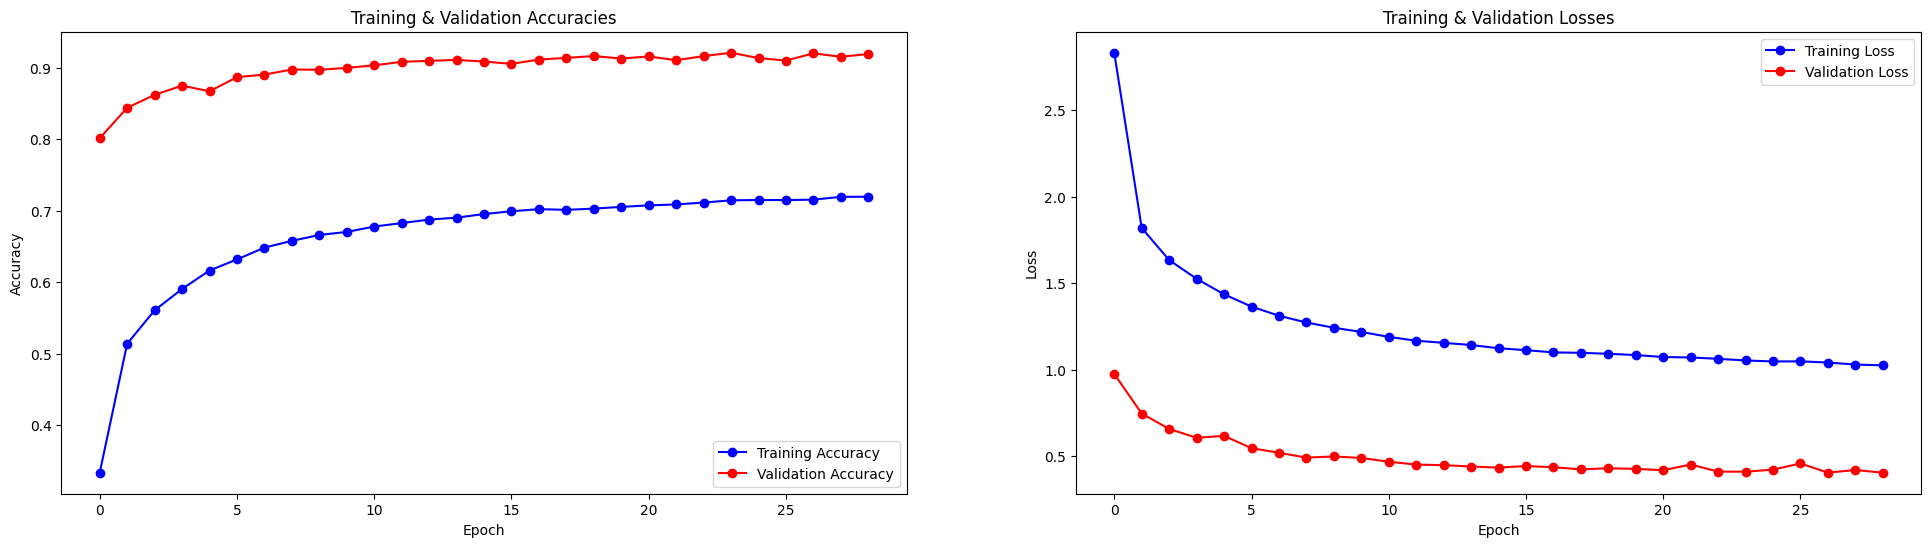

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(24, 6))  # 1 row, 2 columns

# Plot Training & Validation Accuracy
ax[0].plot(training_history.history["accuracy"], '-o', label="Training Accuracy", color="b")
ax[0].plot(training_history.history["val_accuracy"], '-o', label="Validation Accuracy", color="r")
ax[0].set_title("Training & Validation Accuracies")
ax[0].set_xlabel("Epoch")
ax[0].set_ylabel("Accuracy")
ax[0].legend()

# Plot Training & Validation Loss
ax[1].plot(training_history.history["loss"], '-o', label="Training Loss", color="b")
ax[1].plot(training_history.history["val_loss"], '-o', label="Validation Loss", color="r")
ax[1].set_title("Training & Validation Losses")
ax[1].set_xlabel("Epoch")
ax[1].set_ylabel("Loss")
ax[1].legend()

plt.show()

The low training accuracy and high loss are artifacts of using dropout (without dropout or with very low dropout rate, the model had worse performace on the dev set), in the following, I print the accuracy of the model per dataset:

In [ ]:
cnn_eval = cnn.evaluate(X_test, Y_test)
print("Test Set Accuracy: {}".format(cnn_eval[1]))
cnn_eval = cnn.evaluate(X_train, Y_train)
print("Train Set Accuracy: {}".format(cnn_eval[1]))
cnn_eval = cnn.evaluate(X_dev, Y_dev)
print("Dev Set Accuracy: {}".format(cnn_eval[1]))

796/796 [==============================] - 5s 7ms/step - loss: 0.3946 - accuracy: 0.9213
Test Set Accuracy: 0.9212604761123657
6403/6403 [==============================] - 38s 6ms/step - loss: 0.3212 - accuracy: 0.9289
Train Set Accuracy: 0.9288809895515442
796/796 [==============================] - 3s 4ms/step - loss: 0.4033 - accuracy: 0.9191
Dev Set Accuracy: 0.9190994501113892


In [ ]:
# Saving the model for later use
cnn.save('/content/drive/MyDrive/PFam/cnn.h5')

---
A new session can be started from here (next day). You can disconnect and delete runtime to clean all the unnecessary memory. We will reload the raw data and training model from the disk in a couple of minutes

**2- Examining if the model generalized to unseen protiens families via unsupervized clustering**

In [ ]:
# Libraries needed for data analysis
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# connecting drive
from google.colab import drive
drive.mount('/content/drive')

# Reload the original data
!unzip drive/MyDrive/PFam/archive.zip >> /tmp/log.txt && echo "data unzipped"

def read_all_shards(partition='dev', data_dir="random_split/random_split/"):
    shards = []
    for fn in os.listdir(os.path.join(data_dir, partition)):
        with open(os.path.join(data_dir, partition, fn)) as f:
            shards.append(pd.read_csv(f, index_col=None))
    return pd.concat(shards)
test = read_all_shards('test')
dev = read_all_shards('dev')
train = read_all_shards('train')

# Reloading the model
import keras
cnn = keras.models.load_model('/content/drive/MyDrive/PFam/cnn.h5')

Mounted at /content/drive
data unzipped


In [ ]:
# Verifying that the model is loaded and inspecting its structure
cnn.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 150, 16)           352       
                                                                 
 conv1d_8 (Conv1D)           (None, 150, 20)           1620      
                                                                 
 batch_normalization_8 (Bat  (None, 150, 20)           80        
 chNormalization)                                                
                                                                 
 max_pooling1d_8 (MaxPoolin  (None, 75, 20)            0         
 g1D)                                                            
                                                                 
 conv1d_9 (Conv1D)           (None, 75, 12)            732       
                                                                 
 batch_normalization_9 (Bat  (None, 75, 12)           

Removing the output classifier from the cnn model, to use it as an embedder to unseen data

In [ ]:
# Creating a subset of the previous model, including all layers except the output (and the dropout, although it won't be active)
cnn_embedding = keras.models.Model(inputs=cnn.input, outputs=cnn.get_layer('dense_8').output)

# Verify the structure of the subset model
cnn_embedding.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4_input (InputLa  [(None, 150)]             0         
 yer)                                                            
                                                                 
 embedding_4 (Embedding)     (None, 150, 16)           352       
                                                                 
 conv1d_8 (Conv1D)           (None, 150, 20)           1620      
                                                                 
 batch_normalization_8 (Bat  (None, 150, 20)           80        
 chNormalization)                                                
                                                                 
 max_pooling1d_8 (MaxPoolin  (None, 75, 20)            0         
 g1D)                                                            
                                                             

The previous (train, dev, test) is not longer needed to evaluate if the model has meaniningful embedding to unseen families. We can combine all the unseed families into a single set, and call it "target"

In [ ]:
# Combine the previous sets
target = pd.concat([train, dev, test])

In [ ]:
# Remove from target set all families that were already seen by the network
# (remove the families that had more than 500 examples in the train set)
family_sizes = train.groupby('family_id').size()
threshold = 500  # same threshold used before
families_to_keep = family_sizes[(family_sizes <= threshold)]
target = target[target['family_id'].isin(families_to_keep.index)]

In [ ]:
# Now keeping only the 50 most common unseen families (a value arbitrary chosen for better visual illustration)
keep_first = 50
family_sizes = target.groupby('family_id').size()
families_to_keep = family_sizes.sort_values(ascending=False)[:keep_first]
target = target[target['family_id'].isin(families_to_keep.index)]

In [ ]:
# Tokenize the target set (repeating operations explained above)
from keras.preprocessing import sequence
from tensorflow.keras.layers import TextVectorization

Letters_threshold = 20 # same threshold used before
Trucation_threshold = 150 # same threshold used before

tokenizer = TextVectorization(split='character', max_tokens=Letters_threshold + 2)
tokenizer.adapt(target["sequence"])

# Tokenizing the target set
X_target = tokenizer(target["sequence"])
X_target = sequence.pad_sequences(X_target, maxlen=Trucation_threshold, truncating='post')

In [ ]:
# Using the cnn model (the subset we created without output layer) to embed the target
target_embedding = cnn_embedding.predict(X_target)

934/934 [==============================] - 5s 5ms/step


In [ ]:
# Mapping the target embeddings to 2 axes (for visualization) using default TSNE settings
from sklearn.manifold import TSNE
x_tsne = TSNE(n_components=2).fit_transform(target_embedding)

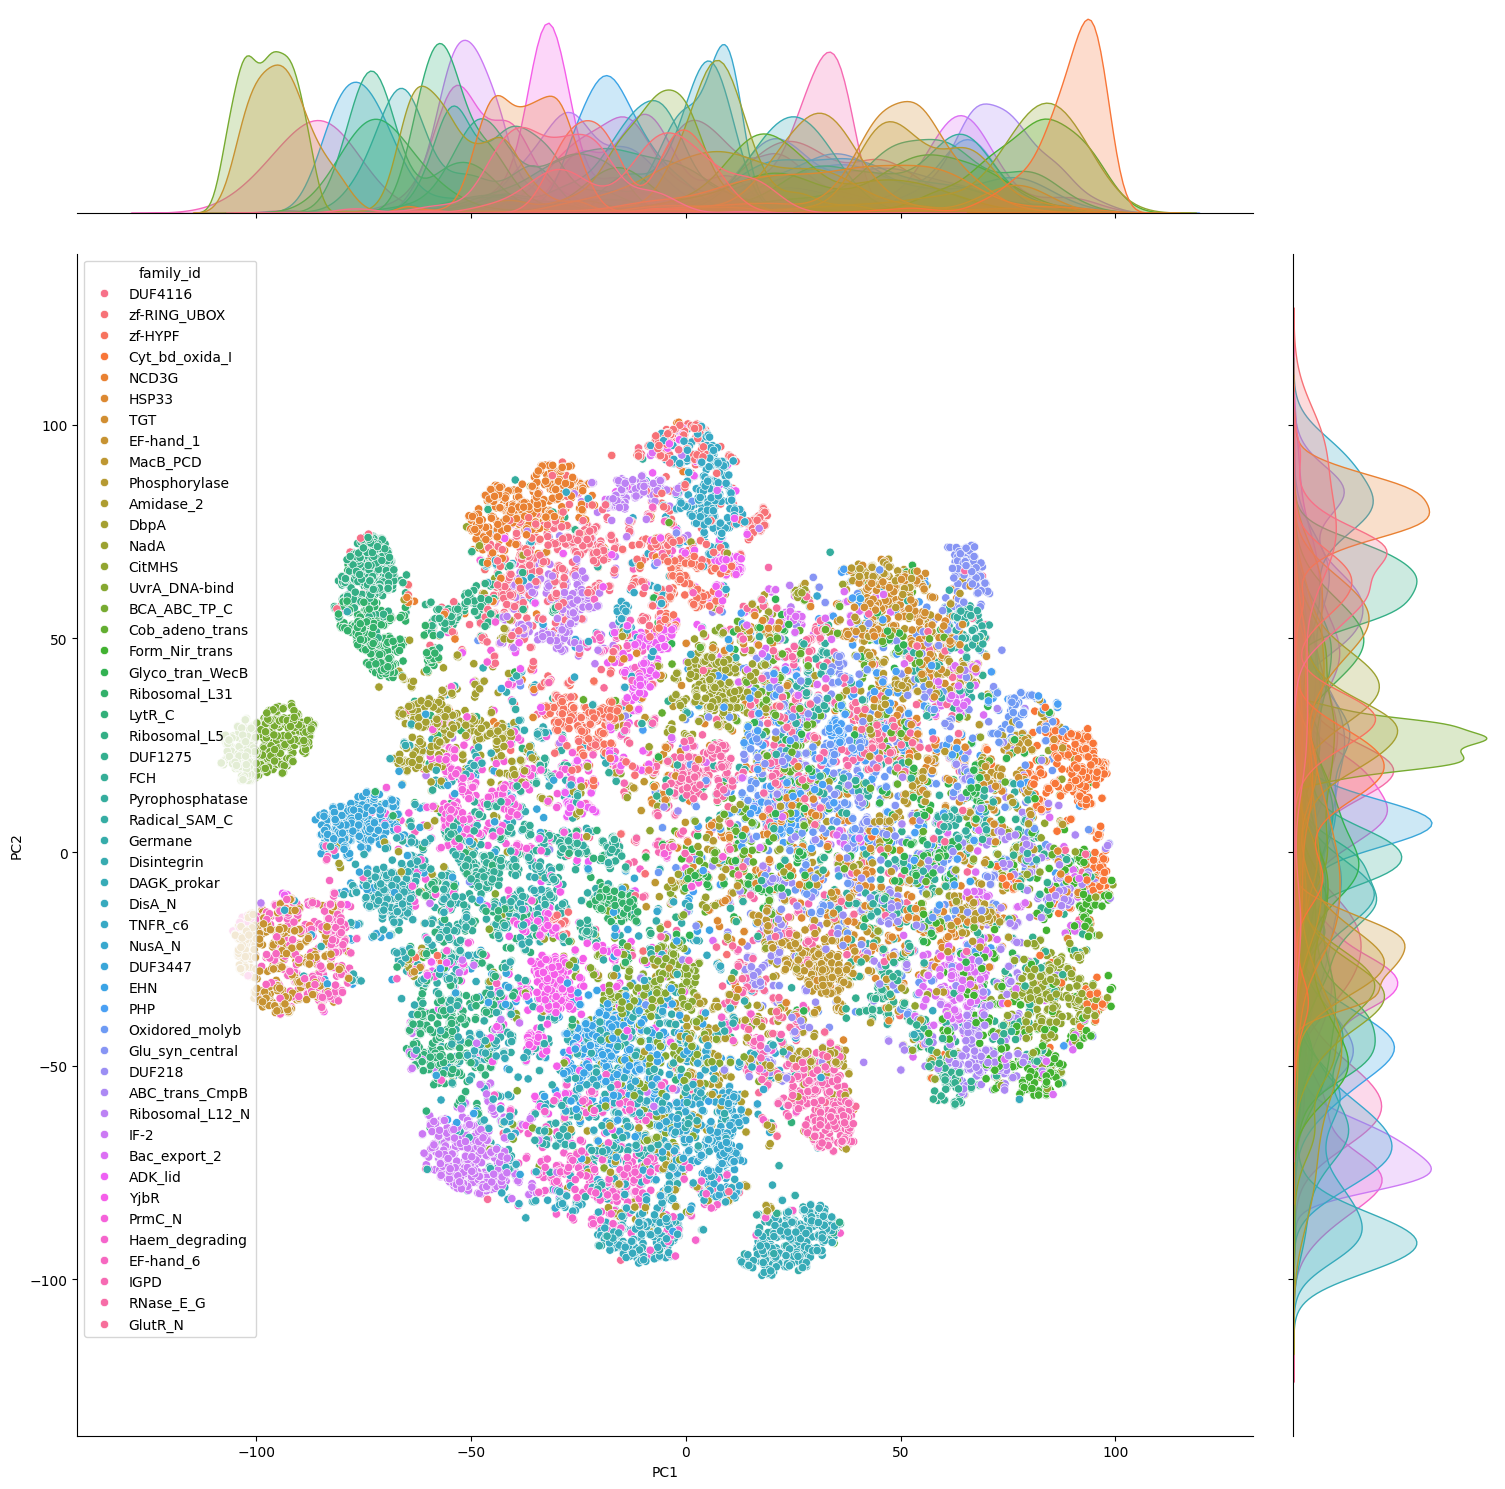

In [ ]:
# Joint plotting the cnn embedding followed by tsne mapping, colored based on the groundtruth families
import seaborn as sns

plot_df = target[["family_id"]].copy()
plot_df["PC1"] = x_tsne[:,0]
plot_df['PC2'] = x_tsne[:,1]

sns.jointplot(data=plot_df, x='PC1', y='PC2', hue = 'family_id', height=15)

It seems that the CNN based embedding was useful to cluster some of the unseen families!

# Results analysis

This notebook provided an exploratory study of the PFam dataset, pointed out to challenges related to classifying protiens into corresponding families, and provided practical considerations that allowed a simple proof-of-concept towards a CNN-based solution.

The CNN-based model trained in this notebook, despite its simplicity, was able to learn to classify the 285 most populated families with ~92% test accuracy. The number of families (i.e., 285) used for training was arbitrary, keeping all families with at least 500 training examples.

The trained model on a subset of the most populated families was shown to give promising preliminary results when used for embedding sequences for 50 unseen families (a threshold used for better visualization). This analysis was done by mapping the sequences to a lower dimensional space (of two principle components) via tsne (Van der Maarten et al.). The visual inspection of this space shows some clear seperation for some families into clusters, and some mixed levels of less seperation for other families (see figure above).

The practical considerations employed in this work, mainly in the over simplification of the CNN, and using a small subset of the families (i.e., 285) were necessary for computational efficiency. Hence, this notebook, and the results achieved by Bileschi at al., agree that a proper design of a CNN and training on more example of protien families can lead to better results.

Nevertheless, a citing literature proposed including more features, that can be available about the protiens along with their sequences, to improve the performance of these network. I anticipate, based on my understanding of the literature on how human-experts classify proteins into families (Mistry et al.), that using the atomic structures of these sequences, as done by human experts, might lead to better deep learning-based classification performance. Nevertheless, more features will require even higher computational resorces.

Van der Maaten, Laurens, and Geoffrey Hinton. "Visualizing data using t-SNE." Journal of machine learning research 9.11 (2008).

Mistry, Jaina, et al. "Pfam: The protein families database in 2021." Nucleic acids research 49.D1 (2021): D412-D419. https://doi.org/10.1093/nar/gkaa913
